# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X, y), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

170508288/170498071 [==============================] - 6s 0us/step
(40000, 32, 32, 3) (40000, 1)


In [ ]:
print(X_val.shape, y_val.shape)

Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

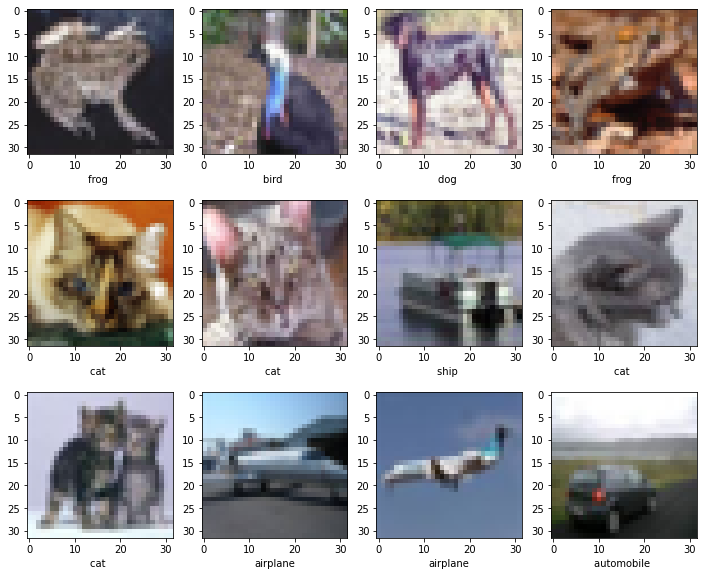

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras
from keras import layers as L
from keras import backend as K

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
y_train, y_val = (tf.keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 181 kB 46.9 MB/s 
     |████████████████████████████████| 144 kB 48.0 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0faf5521a199c752ed870aa60ed82c9f4a4b5dffa63fd3dc969b9a8600c3f058
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import wandb

# wandb.login() Не удается понять, что тут необходимо писать! Как залогиниться?

# wandb.init()

callbacks = [
             tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [ ]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
    optimizer='adam',
    metrics=["accuracy"],
)

С SGD не смог оптимизировать сеть до 45% accuracy, использую Adam

In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
)

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
pred=model.predict(X_test) 
pred_classes=np.argmax(pred, axis=1)

test_acc = accuracy_score(y_test, pred_classes)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.4997
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
model_1 = keras.Sequential([
    keras.layers.Conv2D(
        filters = 10,
        kernel_size = (3,3),
        padding = 'same',
        activation = 'relu',
        input_shape = X_train.shape[1:]),
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        padding = 'valid'),

    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_1.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
    optimizer='adam',
    metrics=["accuracy"],
)

In [ ]:
model_1.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
)

Epoch 1/30
20/20 - 2s - loss: 2.1461 - accuracy: 0.2403 - val_loss: 1.9403 - val_accuracy: 0.3335 - 2s/epoch - 101ms/step
Epoch 2/30
20/20 - 1s - loss: 1.8539 - accuracy: 0.3607 - val_loss: 1.7902 - val_accuracy: 0.3733 - 960ms/epoch - 48ms/step
Epoch 3/30
20/20 - 1s - loss: 1.7336 - accuracy: 0.4022 - val_loss: 1.6997 - val_accuracy: 0.4052 - 982ms/epoch - 49ms/step
Epoch 4/30
20/20 - 1s - loss: 1.6516 - accuracy: 0.4288 - val_loss: 1.6232 - val_accuracy: 0.4394 - 783ms/epoch - 39ms/step
Epoch 5/30
20/20 - 1s - loss: 1.5793 - accuracy: 0.4552 - val_loss: 1.5763 - val_accuracy: 0.4485 - 771ms/epoch - 39ms/step
Epoch 6/30
20/20 - 1s - loss: 1.5264 - accuracy: 0.4720 - val_loss: 1.5193 - val_accuracy: 0.4679 - 766ms/epoch - 38ms/step
Epoch 7/30
20/20 - 1s - loss: 1.4812 - accuracy: 0.4834 - val_loss: 1.4856 - val_accuracy: 0.4834 - 735ms/epoch - 37ms/step
Epoch 8/30
20/20 - 1s - loss: 1.4440 - accuracy: 0.4988 - val_loss: 1.4671 - val_accuracy: 0.4870 - 747ms/epoch - 37ms/step
Epoch 9/30

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
pred_1=model_1.predict(X_test) 
pred_1_classes=np.argmax(pred_1, axis=1)

test_acc_1 = accuracy_score(y_test, pred_1_classes)
print("\n Test_acc_1 =", test_acc_1)
assert test_acc_1 > 0.5, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc_1 = 0.5956
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            predict = model.predict(X_test)
            predict_classes = np.argmax(predict, axis=1)
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, predict_classes)))

In [ ]:
!rm -rf ./logs

In [ ]:
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'Adam': tf.keras.optimizers.Adam(),
    'RMSprop': tf.keras.optimizers.RMSprop()
    # 'optimizer_name': optimizer
}

In [ ]:
evaluator = Evaluator(model_1, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

Final score of single_model_SGD is 0.5848
Final score of single_model_Adam is 0.547
Final score of single_model_RMSprop is 0.5621


Прокомментируйте полученные результаты.

Вариант с оптимизацией по SGD вышла немногим лучше, ожидал лучшего качества модели с Adam оптимизацией

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [ ]:
model_2 = keras.Sequential([
    keras.layers.Conv2D(
        filters = 10,
        kernel_size = (3,3),
        padding = 'same',
        activation = 'relu',
        input_shape = X_train.shape[1:]),
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        padding = 'valid'),

    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model_2.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
    optimizer='adam',
    metrics=["accuracy"],
)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

model_2.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
)

pred_2=model_2.predict(X_test) 
pred_2_classes=np.argmax(pred_2, axis=1)

test_acc_2 = accuracy_score(y_test, pred_2_classes)
print("\n Test_acc_2 =", test_acc_2)

Epoch 1/30
20/20 - 2s - loss: 1.9721 - accuracy: 0.3235 - val_loss: 2.1127 - val_accuracy: 0.2608 - 2s/epoch - 97ms/step
Epoch 2/30
20/20 - 1s - loss: 1.5830 - accuracy: 0.4477 - val_loss: 2.0533 - val_accuracy: 0.2996 - 808ms/epoch - 40ms/step
Epoch 3/30
20/20 - 1s - loss: 1.4005 - accuracy: 0.5116 - val_loss: 2.0380 - val_accuracy: 0.3423 - 809ms/epoch - 40ms/step
Epoch 4/30
20/20 - 1s - loss: 1.2763 - accuracy: 0.5538 - val_loss: 2.0060 - val_accuracy: 0.4114 - 804ms/epoch - 40ms/step
Epoch 5/30
20/20 - 1s - loss: 1.1781 - accuracy: 0.5870 - val_loss: 1.9940 - val_accuracy: 0.4052 - 766ms/epoch - 38ms/step
Epoch 6/30
20/20 - 1s - loss: 1.1001 - accuracy: 0.6155 - val_loss: 1.9699 - val_accuracy: 0.3869 - 800ms/epoch - 40ms/step
Epoch 7/30
20/20 - 1s - loss: 1.0324 - accuracy: 0.6410 - val_loss: 1.9202 - val_accuracy: 0.4224 - 758ms/epoch - 38ms/step
Epoch 8/30
20/20 - 1s - loss: 0.9776 - accuracy: 0.6596 - val_loss: 1.8685 - val_accuracy: 0.4560 - 820ms/epoch - 41ms/step
Epoch 9/30


Прокомментируйте полученные результаты.

Качество на тренировочных данных приближается к максимуму, однако мы видим переобучение, необходимо добавить DropOut

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

У меня так и не вышло построить кривую, но предположу по аналогии ROC AUC, лучшая кривая та, под которой охватывается большая площадь

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [ ]:
def get_best_model(batch_size=2048, filters = [10, 16], kernel_size = [(5,5), (5,5)], hid_size=[100, 100], dropout=[0.1, 0,1], verbose=0):
    model = keras.Sequential([
        keras.layers.Conv2D(
            filters = filters[0],
            kernel_size = kernel_size[0],
            padding = 'same',
            activation = 'relu',
            input_shape = X_train.shape[1:]),
        keras.layers.MaxPool2D(
            pool_size = (2,2),
            padding = 'valid'),

        keras.layers.Conv2D(
            filters = filters[1],
            kernel_size = kernel_size[1],
            padding = 'same',
            activation = 'relu'),
        keras.layers.MaxPool2D(
            pool_size = (2,2),
            padding = 'valid'),

        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(hid_size[0], activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hid_size[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
        optimizer='adam',
        metrics=["accuracy"],
    )

    callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    ]

    model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=30,
        verbose=verbose,
        callbacks=callbacks,
        validation_data=(X_val, y_val),
    )

    pred=model.predict(X_test) 
    pred_classes=np.argmax(pred, axis=1)

    test_acc = accuracy_score(y_test, pred_classes)
    print("\n Test_acc =", test_acc)

    return model

In [ ]:
model_3 = get_best_model()


 Test_acc = 0.6323


In [ ]:
model_4 = get_best_model(batch_size=2048, filters = [10, 16], kernel_size = [(5,5), (5,5)], hid_size=[32, 32], dropout=[0.1, 0,1], verbose=0)
# Изменил кол-во нейтронов


 Test_acc = 0.6264


In [ ]:
model_5 = get_best_model(batch_size=4096, filters = [10, 16], kernel_size = [(5,5), (5,5)], hid_size=[100, 100], dropout=[0.1, 0,1], verbose=0)
# bath_size = 4096


 Test_acc = 0.5918


In [ ]:
model_6 = get_best_model(batch_size=2048, filters = [16, 32], kernel_size = [(5,5), (5,5)], hid_size=[100, 100], dropout=[0.1, 0,1], verbose=0)
# Кол-во фильтров


 Test_acc = 0.6556


In [ ]:
model_7 = get_best_model(batch_size=2048, filters = [16, 32], kernel_size = [(3,3), (3,3)], hid_size=[100, 100], dropout=[0.1, 0,1], verbose=0)
# размеры матриц и кол-во фильтров


 Test_acc = 0.6595


In [ ]:
model_8 = get_best_model(batch_size=4096, filters = [32, 64], kernel_size = [(5,5), (5,5)], hid_size=[256, 256], dropout=[0.3, 0,3], verbose=1)


Epoch 1/30
10/10 [==============================] - 12s 870ms/step - loss: 2.0757 - accuracy: 0.2640 - val_loss: 2.2078 - val_accuracy: 0.2212
Epoch 2/30
10/10 [==============================] - 3s 323ms/step - loss: 1.6063 - accuracy: 0.4182 - val_loss: 2.1753 - val_accuracy: 0.2490
Epoch 3/30
10/10 [==============================] - 3s 318ms/step - loss: 1.4040 - accuracy: 0.4932 - val_loss: 2.1651 - val_accuracy: 0.2901
Epoch 4/30
10/10 [==============================] - 3s 317ms/step - loss: 1.2797 - accuracy: 0.5411 - val_loss: 2.1456 - val_accuracy: 0.3478
Epoch 5/30
10/10 [==============================] - 3s 317ms/step - loss: 1.1684 - accuracy: 0.5803 - val_loss: 2.1202 - val_accuracy: 0.3897
Epoch 6/30
10/10 [==============================] - 3s 324ms/step - loss: 1.0744 - accuracy: 0.6191 - val_loss: 2.1058 - val_accuracy: 0.4969
Epoch 7/30
10/10 [==============================] - 3s 322ms/step - loss: 0.9952 - accuracy: 0.6473 - val_loss: 2.0814 - val_accuracy: 0.5601
Epoch

In [ ]:
model_9 = get_best_model(batch_size=4096, filters = [32, 64], kernel_size = [(5,5), (5,5)], hid_size=[256, 256], dropout=[0.4, 0,4], verbose=1)


Epoch 1/30
10/10 [==============================] - 4s 359ms/step - loss: 2.0790 - accuracy: 0.2643 - val_loss: 2.2247 - val_accuracy: 0.2241
Epoch 2/30
10/10 [==============================] - 3s 320ms/step - loss: 1.6090 - accuracy: 0.4195 - val_loss: 2.2094 - val_accuracy: 0.3319
Epoch 3/30
10/10 [==============================] - 3s 318ms/step - loss: 1.4069 - accuracy: 0.4913 - val_loss: 2.1851 - val_accuracy: 0.3708
Epoch 4/30
10/10 [==============================] - 3s 324ms/step - loss: 1.2549 - accuracy: 0.5501 - val_loss: 2.1733 - val_accuracy: 0.4379
Epoch 5/30
10/10 [==============================] - 3s 323ms/step - loss: 1.1357 - accuracy: 0.5923 - val_loss: 2.1423 - val_accuracy: 0.5018
Epoch 6/30
10/10 [==============================] - 3s 316ms/step - loss: 1.0348 - accuracy: 0.6328 - val_loss: 2.1299 - val_accuracy: 0.5575
Epoch 7/30
10/10 [==============================] - 3s 323ms/step - loss: 0.9478 - accuracy: 0.6640 - val_loss: 2.0827 - val_accuracy: 0.5480
Epoch 

In [ ]:
model_10 = get_best_model(batch_size=4096, filters = [64, 128], kernel_size = [(5,5), (5,5)], hid_size=[256, 256], dropout=[0.4, 0,4], verbose=1)

Epoch 1/30
10/10 [==============================] - 7s 662ms/step - loss: 2.0850 - accuracy: 0.2589 - val_loss: 2.2327 - val_accuracy: 0.2479
Epoch 2/30
10/10 [==============================] - 6s 640ms/step - loss: 1.5983 - accuracy: 0.4222 - val_loss: 2.2200 - val_accuracy: 0.2642
Epoch 3/30
10/10 [==============================] - 6s 646ms/step - loss: 1.3938 - accuracy: 0.4976 - val_loss: 2.1868 - val_accuracy: 0.2950
Epoch 4/30
10/10 [==============================] - 6s 624ms/step - loss: 1.2425 - accuracy: 0.5538 - val_loss: 2.1706 - val_accuracy: 0.3828
Epoch 5/30
10/10 [==============================] - 6s 641ms/step - loss: 1.1209 - accuracy: 0.5998 - val_loss: 2.1575 - val_accuracy: 0.4569
Epoch 6/30
10/10 [==============================] - 6s 623ms/step - loss: 1.0300 - accuracy: 0.6319 - val_loss: 2.1333 - val_accuracy: 0.5245
Epoch 7/30
10/10 [==============================] - 6s 625ms/step - loss: 0.9337 - accuracy: 0.6681 - val_loss: 2.1066 - val_accuracy: 0.5135
Epoch 

In [ ]:
model_11 = get_best_model(batch_size=4096, filters = [64, 128], kernel_size = [(5,5), (5,5)], hid_size=[256, 256], dropout=[0.5, 0,5], verbose=1)


Epoch 1/30
10/10 [==============================] - 7s 682ms/step - loss: 2.2559 - accuracy: 0.2255 - val_loss: 2.2433 - val_accuracy: 0.2490
Epoch 2/30
10/10 [==============================] - 6s 646ms/step - loss: 1.7094 - accuracy: 0.3832 - val_loss: 2.2218 - val_accuracy: 0.2895
Epoch 3/30
10/10 [==============================] - 6s 646ms/step - loss: 1.5049 - accuracy: 0.4565 - val_loss: 2.2001 - val_accuracy: 0.3086
Epoch 4/30
10/10 [==============================] - 6s 645ms/step - loss: 1.3592 - accuracy: 0.5101 - val_loss: 2.1810 - val_accuracy: 0.3709
Epoch 5/30
10/10 [==============================] - 6s 625ms/step - loss: 1.2528 - accuracy: 0.5494 - val_loss: 2.1544 - val_accuracy: 0.3990
Epoch 6/30
10/10 [==============================] - 6s 646ms/step - loss: 1.1503 - accuracy: 0.5847 - val_loss: 2.1423 - val_accuracy: 0.4386
Epoch 7/30
10/10 [==============================] - 6s 625ms/step - loss: 1.0642 - accuracy: 0.6177 - val_loss: 2.0946 - val_accuracy: 0.4959
Epoch 

Попробуем поперебирать гиперпараметры с помощью KerasTuner

In [ ]:
pip install -U keras-tuner

     |████████████████████████████████| 98 kB 3.9 MB/s 


Подберем гиперпараметры с помощью RandomSearch

In [ ]:
from kerastuner.tuners import RandomSearch, BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy




In [ ]:
def build_model(hp):
    model = Sequential()

    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])

    model.add(Conv2D(
                filters = hp.Int('filters_1', min_value=8, max_value=64, step=4),
                kernel_size = (5,5),
                padding = 'same',
                activation = activation_choice,
                input_shape = X_train.shape[1:]))
    model.add(MaxPool2D(
                pool_size = (2,2),
                padding = 'valid'))
    
    model.add(Conv2D(
                filters = hp.Int('filters_2', min_value=8, max_value=64, step=4),
                kernel_size = (5,5),
                padding = 'same',
                activation = activation_choice))
    model.add(MaxPool2D(
                pool_size = (2,2),
                padding = 'valid'))

    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_1', min_value=64, max_value=1024, step=64), 
                                 activation=activation_choice))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(units=hp.Int('dense_2', min_value=64, max_value=1024, step=64), 
                                 activation=activation_choice))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(10, activation='softmax'))

    model.compile(
        loss=CategoricalCrossentropy(),
        # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        metrics=["accuracy"],
    )

    callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    ]

    return model

In [ ]:
tuner = RandomSearch(
    build_model,                
    objective='val_accuracy',    
                                 
    max_trials=10,              
    directory='test_directory'  
    )

INFO:tensorflow:Reloading Oracle from existing project test_directory/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from test_directory/untitled_project/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 4, 'sampling': None}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 4, 'sampling': None}
dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
dense_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': None}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(X_train,                
             y_train,                 
             batch_size=2048,          
             epochs=30,               
             validation_split=0.2,    
             )

INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=3)

In [ ]:
for model in models:
  model.summary()

  pred=model.predict(X_test) 
  pred_classes=np.argmax(pred, axis=1)

  test_acc = accuracy_score(y_test, pred_classes)
  print("\n Test_acc =", test_acc)
  
  print() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 28)        2128      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 28)        19628     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 28)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 28)         112       
 ormalization)                                                   
                                                        

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 